In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
import pandas as pd
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.applications import MobileNetV2


In [4]:
base_dir = '/content/drive/MyDrive/Deep Learning/TransferLearning'
sub_dirs = ['train', 'test', 'valid']

dataframes = {}
for sub_dir in sub_dirs:
    df = pd.read_csv(os.path.join(base_dir, sub_dir, '_classes.csv'))
    df['filepath'] = base_dir + '/' + sub_dir + '/' + df['filename']
    dataframes[sub_dir] = df

train_df = dataframes['train']
test_df = dataframes['test']
val_df = dataframes['valid']

print(train_df['filepath'][10])

/content/drive/MyDrive/Deep Learning/TransferLearning/train/IMG_0091_jpg.rf.0baa87da245e74232a4d3edae11bec6c.jpg


In [5]:
# Loading the dataset
IMAGE_SIZE = (224, 224)

def load_data(df):
    images = np.array([img_to_array(load_img(row['filepath'], target_size=IMAGE_SIZE)) / 255.0 for _, row in df.iterrows()])
    labels = df[[' dog', ' person']].values
    return images, labels

train_images, train_labels = load_data(train_df)
valid_images, valid_labels = load_data(val_df)
test_images, test_labels = load_data(test_df)

In [6]:
# Data augmentation to expand the available dataset
def random_flip(image):
    return tf.image.random_flip_left_right(image)

def random_rotation(image):
    angle = np.random.uniform(-15, 15)
    image = tf.keras.preprocessing.image.apply_affine_transform(image, theta=angle)
    return tf.convert_to_tensor(image)

def random_zoom(image, zoom_range=(0.8, 1.2)):
    zoom = np.random.uniform(*zoom_range)
    image = tf.image.resize(image, [int(image.shape[0] * zoom), int(image.shape[1] * zoom)])
    return tf.image.resize_with_crop_or_pad(image, 224, 224)

def random_shift(image, width_shift_range=0.2, height_shift_range=0.2):
    width_shift = tf.random.uniform([], -width_shift_range, width_shift_range) * image.shape[1]
    height_shift = tf.random.uniform([], -height_shift_range, height_shift_range) * image.shape[0]
    return tf.keras.preprocessing.image.apply_affine_transform(
        image.numpy(), tx=height_shift, ty=width_shift, fill_mode="reflect"
    )

def augment_image(image):
    image = tf.convert_to_tensor(image)
    image = random_flip(image)
    image = random_rotation(image)
    image = random_zoom(image)
    image = random_shift(image)
    return tf.image.resize(image, [224, 224])

augmented_train_images = []
augmented_train_labels = []

for img, label in zip(train_images, train_labels):
    augmented_image = augment_image(img).numpy()
    augmented_train_images.append(augmented_image)
    augmented_train_labels.append(label)

# Converting lists to NumPy arrays
augmented_train_images = np.array(augmented_train_images, dtype=np.float32)
augmented_train_labels = np.array(augmented_train_labels, dtype=np.float32)

# Appending augmented data to the original dataset
expanded_train_images = np.concatenate((train_images, augmented_train_images), axis=0)
expanded_train_labels = np.concatenate((train_labels, augmented_train_labels), axis=0)

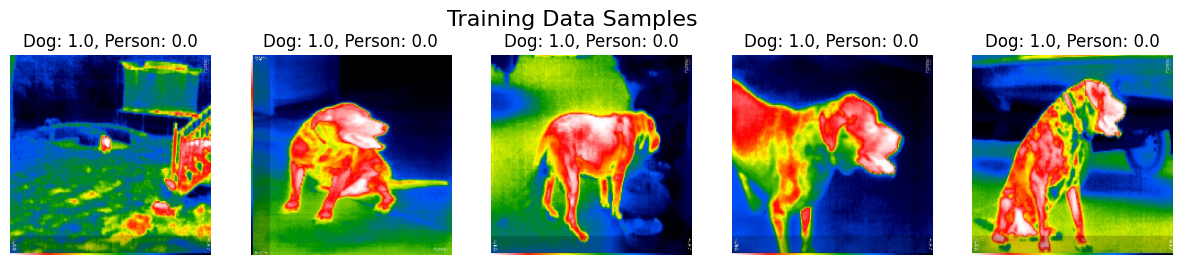

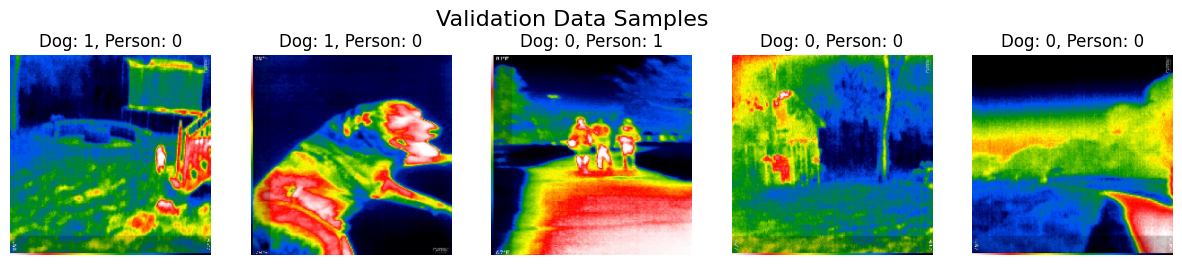

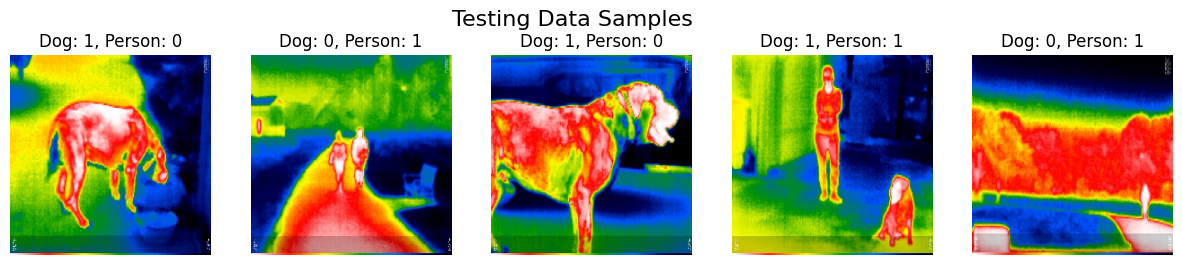

In [7]:
# Sample dataset


def plot_samples(images, labels, title, num_samples=5):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title, fontsize=16)
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        label_text = f"Dog: {labels[i][0]}, Person: {labels[i][1]}"
        plt.title(label_text)
        plt.axis("off")

plot_samples(expanded_train_images, expanded_train_labels, "Training Data Samples", num_samples=5)
plot_samples(valid_images, valid_labels, "Validation Data Samples", num_samples=5)
plot_samples(test_images, test_labels, "Testing Data Samples", num_samples=5)
plt.show()

# CNN Model

In [8]:


# Defining CNN moedl with hyperparameters
def cnn_model(input_shape=(224, 224, 3), learning_rate=0.001, dropout_rate=0.5, l2_reg=0.001):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
                      kernel_regularizer=regularizers.l2(l2_reg)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu',
                      kernel_regularizer=regularizers.l2(l2_reg)),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.Dropout(dropout_rate),
        layers.Dense(2, activation='sigmoid')
    ])

    # Compiling the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning
def tune_hyperparameters():
    learning_rates = [0.001, 0.0001]
    dropout_rates = [0.3, 0.5, 0.7]
    l2_regs = [0.001, 0.0001]

    best_model = None
    best_accuracy = 0
    best_params = {}
    best_history = None

    for lr in learning_rates:
        for dr in dropout_rates:
            for l2 in l2_regs:
                print(f"Training with lr={lr}, dropout={dr}, L2={l2}")
                model = cnn_model(learning_rate=lr, dropout_rate=dr, l2_reg=l2)
                history = model.fit(expanded_train_images, expanded_train_labels,
                                    validation_data=(valid_images, valid_labels),
                                    epochs=5, batch_size=32, verbose=1)

                val_accuracy = history.history['val_accuracy'][-1]
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model = model
                    best_params = {'learning_rate': lr, 'dropout_rate': dr, 'l2_reg': l2}
                    best_history = history

    print(f"Best model parameters: {best_params} with validation accuracy: {best_accuracy}")
    return best_model, best_params, best_history

best_model, best_params, best_history = tune_hyperparameters()

Training with lr=0.001, dropout=0.3, L2=0.001


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5300 - loss: 1.1750 - val_accuracy: 0.6585 - val_loss: 1.0323
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - accuracy: 0.6440 - loss: 1.0093 - val_accuracy: 0.7561 - val_loss: 0.8832
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6424 - loss: 0.8802 - val_accuracy: 0.7805 - val_loss: 0.6171
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6803 - loss: 0.7180 - val_accuracy: 0.8537 - val_loss: 0.5390
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.7991 - loss: 0.6282 - val_accuracy: 0.8780 - val_loss: 0.5500
Training with lr=0.001, dropout=0.3, L2=0.0001
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 599ms/step - accuracy: 0.5958 - loss: 0.7634 - val_accuracy: 0.6585 - val_loss: 0.7018
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6629 - loss: 0.6989 - val_accuracy: 0.7561 - val_loss: 0.5465
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6869 - loss: 0.5940 - 

In [9]:
# Model evaluating on test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6500 - loss: 0.4748
Test Loss: 0.47476691007614136
Test Accuracy: 0.6499999761581421


In [10]:
# Accuracy and loss plot

def plot_training(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

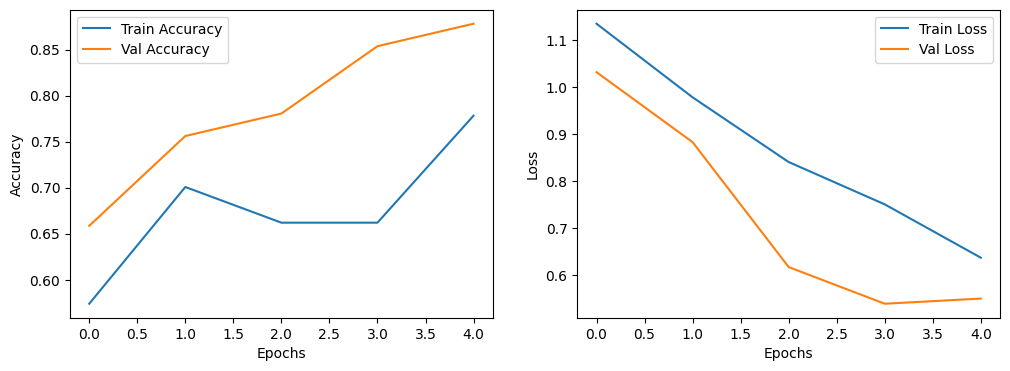

In [11]:
plot_training(best_history)

# ResNet-18 Model

In [12]:


# Defining CNN model with hyperparameters
def resnet18(input_shape=(224, 224, 3), num_classes=2, learning_rate=0.001, dropout_rate=0.5, l2_reg=0.001):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same", kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # Residual block
    def resnet_block(x, filters, strides=1):
        shortcut = x
        x = layers.Conv2D(filters, kernel_size=3, strides=strides, padding="same", kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same", kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.BatchNormalization()(x)

        if strides != 1:
            shortcut = layers.Conv2D(filters, kernel_size=1, strides=strides, kernel_regularizer=regularizers.l2(l2_reg))(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.add([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # Adding filter sizes to resnet blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)
    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    # Global Average Pooling and Dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)  # Multi-label classification

    # Compiling the model
    model = Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Hyperparameter tuning
def tune_resnet_hyperparameters():
    learning_rates = [0.001, 0.0001]
    dropout_rates = [0.3, 0.5]
    l2_regs = [0.001, 0.0001]
    best_model = None
    best_accuracy = 0
    best_params = {}

    for lr in learning_rates:
        for dr in dropout_rates:
            for l2 in l2_regs:
                print(f"Training with lr={lr}, dropout={dr}, L2={l2}")
                model = resnet18(learning_rate=lr, dropout_rate=dr, l2_reg=l2)
                history = model.fit(expanded_train_images, expanded_train_labels,
                                    validation_data=(valid_images, valid_labels),
                                    epochs=5, batch_size=32, verbose=1)
                # Validation accuracy
                val_accuracy = history.history['val_accuracy'][-1]
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model = model
                    best_params = {'learning_rate': lr, 'dropout_rate': dr, 'l2_reg': l2}
                    best_history = history

    print(f"Best model parameters: {best_params} with validation accuracy: {best_accuracy}")
    return best_model, best_params, best_history

best_model, best_params, best_history = tune_resnet_hyperparameters()

Training with lr=0.001, dropout=0.3, L2=0.001
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5579 - loss: 5.4909 - val_accuracy: 0.6585 - val_loss: 28.9416
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.6359 - loss: 4.8426 - val_accuracy: 0.6585 - val_loss: 24.3387
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.7093 - loss: 4.6908 - val_accuracy: 0.7317 - val_loss: 8.0793
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7268 - loss: 4.4425 - val_accuracy: 0.5610 - val_loss: 5.5058
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7467 - loss: 4.1796 - val_accuracy: 0.7317 - val_loss: 4.2665
Training with lr=0.001, dropout=0.3, L2=0.0001
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.4432 - loss: 1.8506 - val_accuracy: 0.3415 - val_loss: 161.5412
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6372 - loss: 1.1764 - val_accuracy: 0.6585 - val_loss: 972.3091
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━

In [13]:
# Mmodel evaluaiton on test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7500 - loss: 4.2806
Test Loss: 4.280649662017822
Test Accuracy: 0.75


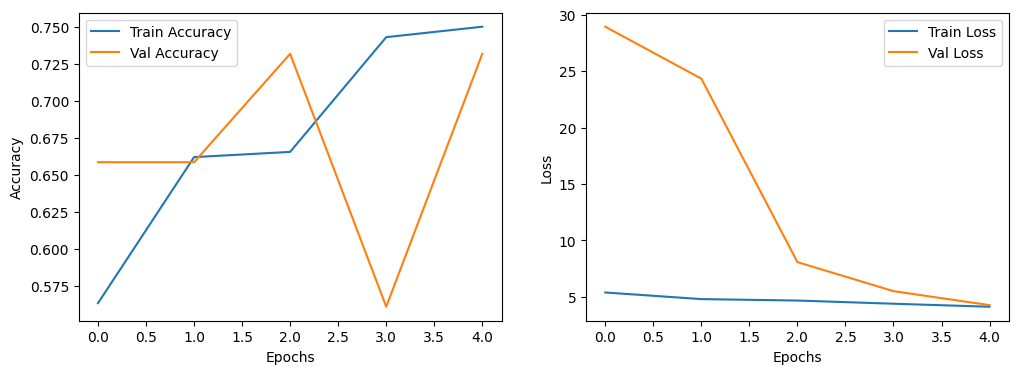

In [14]:
plot_training(best_history)

# MobileNet Model

In [15]:


# Defining a MobileNet model with hyperparameters
def create_mobilenet_model(input_shape=(224, 224, 3), learning_rate=0.001, dropout_rate=0.5, l2_reg=0.001):
    # Loading the MobileNetV2 base model
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    # Freezing the base model layers
    base_model.trainable = False

    # Input layer
    inputs = layers.Input(shape=input_shape)

    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)

    # Output layer
    outputs = layers.Dense(2, activation='sigmoid')(x)  # 2 outputs for "dog" and "person" labels

    # Compiling the model
    model = models.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Hyperparameter tuning
def tune_mobilenet_hyperparameters():
    learning_rates = [0.001, 0.0001]
    dropout_rates = [0.3, 0.5, 0.7]
    l2_regs = [0.001, 0.0001]
    best_model = None
    best_accuracy = 0
    best_params = {}

    for lr in learning_rates:
        for dr in dropout_rates:
            for l2 in l2_regs:
                print(f"Training with lr={lr}, dropout={dr}, L2={l2}")
                model = create_mobilenet_model(learning_rate=lr, dropout_rate=dr, l2_reg=l2)

                # Validaiton accuracy
                history = model.fit(expanded_train_images, expanded_train_labels,
                                    validation_data=(valid_images, valid_labels),
                                    epochs=5, batch_size=32, verbose=1)

                val_accuracy = history.history['val_accuracy'][-1]

                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_model = model
                    best_params = {'learning_rate': lr, 'dropout_rate': dr, 'l2_reg': l2}
                    best_history = history

    print(f"Best model parameters: {best_params} with validation accuracy: {best_accuracy}")
    return best_model, best_params, best_history

best_model, best_params, best_history = tune_mobilenet_hyperparameters()

Training with lr=0.001, dropout=0.3, L2=0.001
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7092 - loss: 1.0138 - val_accuracy: 0.9024 - val_loss: 0.5933
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.8324 - loss: 0.6039 - val_accuracy: 0.8293 - val_loss: 0.4500
Epoch 3/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8214 - loss: 0.5100 - val_accuracy: 0.8293 - val_loss: 0.3941
Epoch 4/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8625 - loss: 0.4057 - val_accuracy: 0.8537 - val_loss: 0.3552
Epoch 5/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8823 - loss: 0.3892 - val_accuracy: 0.8049 - val_loss: 0.3296
Training with lr=0.001, dropout=0.3, L2=0.0001
Epoch 1/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5624 - loss: 0.8065 - val_accuracy: 0.8537 - val_loss: 0.3458
Epoch 2/5
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7764 - loss: 0.4297 - val_accuracy: 0.8537 - val_loss:

In [16]:
# Model evaluation on test data
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8500 - loss: 0.4080
Test Loss: 0.40804916620254517
Test Accuracy: 0.8500000238418579


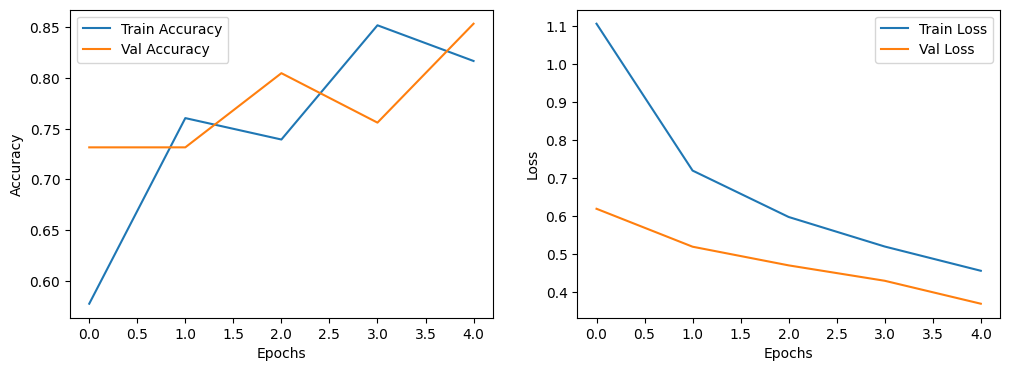

In [17]:
plot_training(best_history)